# Relational queries

Alejandro Morales Sierra  
Centre for Crop Systems Analysis - Wageningen University  
16/03/2023

In this example we illustrate how to test relationships among nodes inside queries.
Relational queries allow to establish relationships between nodes in the graph, 
which generally requires a intimiate knowledge of the graph. For this reason,
relational queries are inheretly complex as graphs can become complex and there
may be solutions that do not require relational queries in many instances.
Nevertheless, they are integral part of VPL and can sometimes be useful. As they
can be hard to grasp, this tutorial will illustrate with a relatively simple
graph a series of relational queries with increasing complexity with the aim
that users will get a better understanding of relational queries. For this purpose, 
an abstract graph with several branching levels will be used, so that we can focus
on the relations among the nodes without being distracted by case-specific details.

The graph will be composed of two types of nodes: the inner nodes (`A` and `C`) and the 
leaf nodes (`B`). Each leaf node will be identified uniquely with an index and
the objective is to write queries that can identify a specific subset of the leaf
nodes, without using the data stored in the nodes themselves. That is, the queries
should select the right nodes based on their relationships to the rest of nodes
in the graph. Note that `C` nodes contain a single value that may be positive or negative, 
whereas `A` nodes contain no data.

As usual, we start with defining the types of nodes in the graph

In [36]:
using VPL

module Queries
    using VPL
    struct A <: Node end

    struct C <: Node
        val::Float64
    end

    struct B <: Node
        ID::Int
    end
end
import .Queries as Q

We generate the graph directly, rather than with rewriting rules. The graph has
a motif that is repeated three times (with a small variation), so we can create
the graph in a piecewise manner. Note how we can use the function `sum` to add
nodes to the graph (i.e. `sum(A() for i in 1:3)` is equivalent to `A() + A() + A()`)

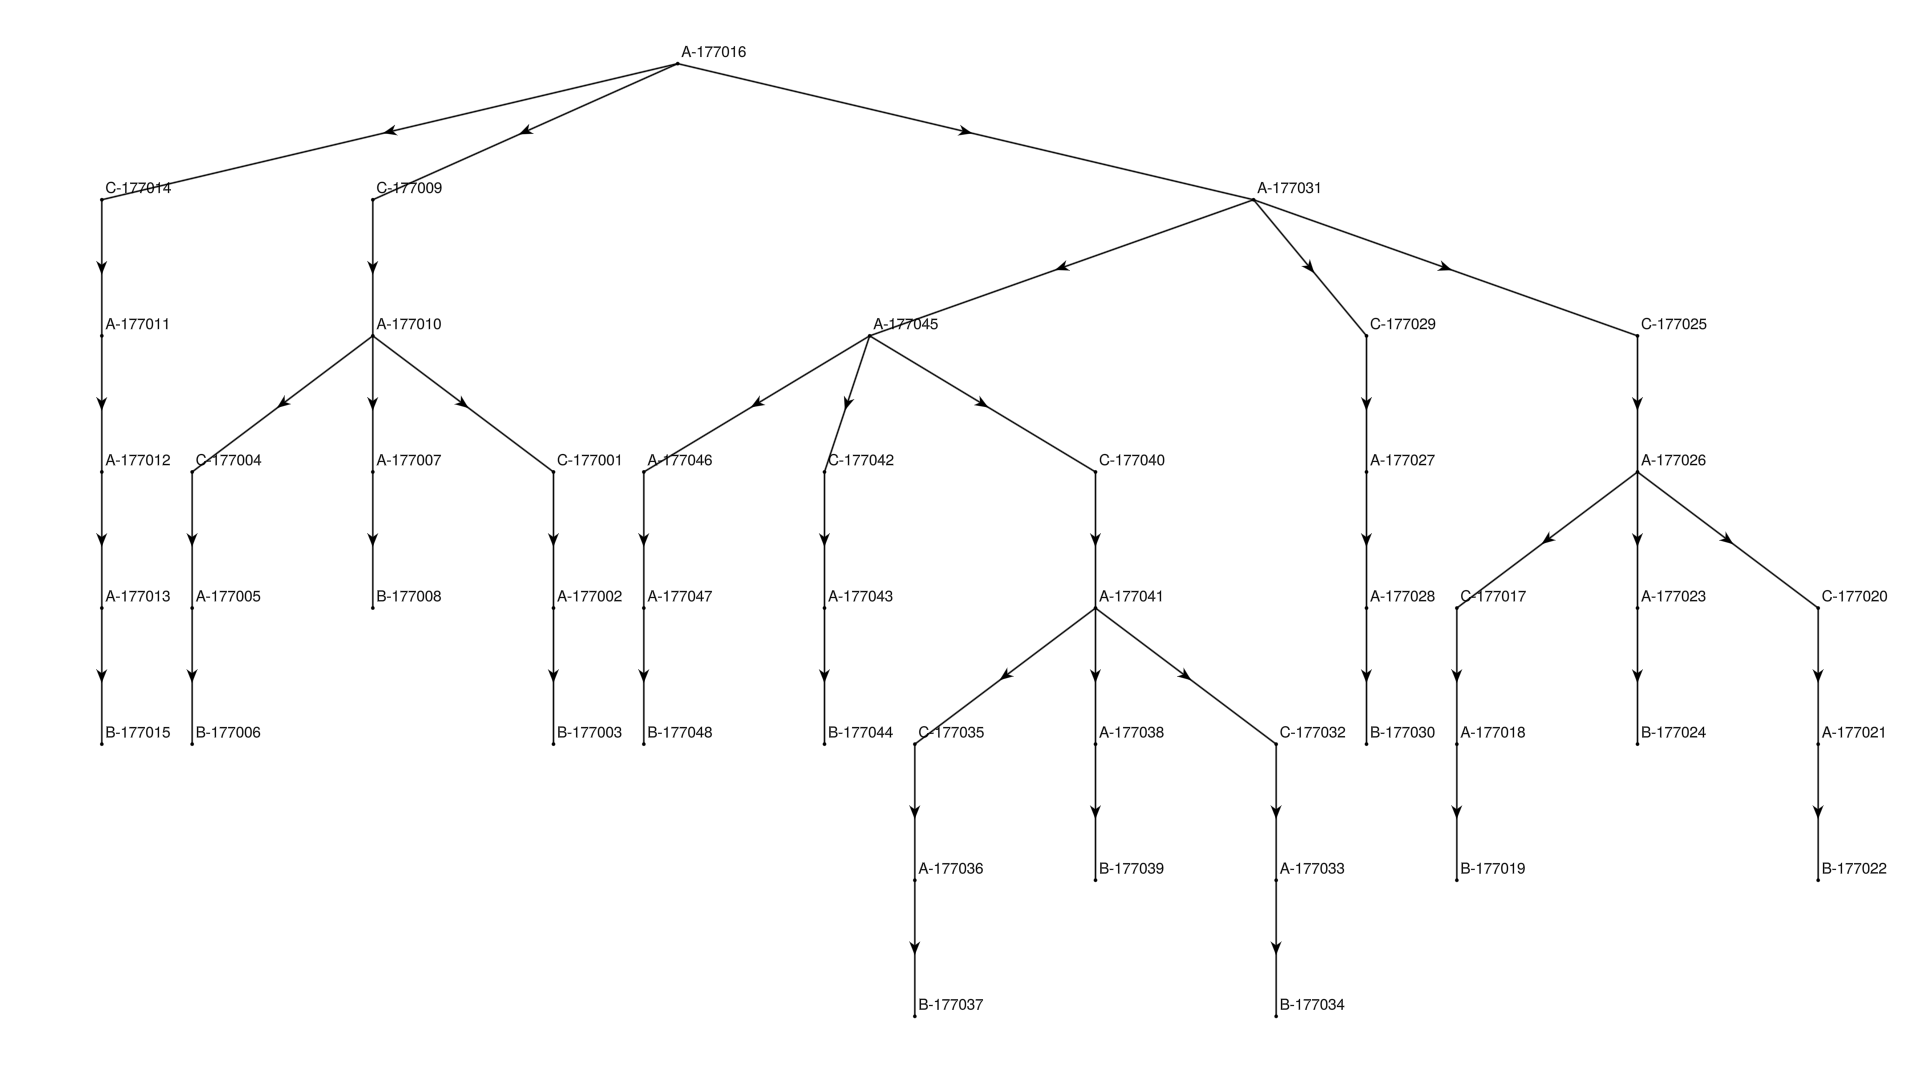

In [37]:
motif(n, i = 0) = Q.A() + (Q.C(45.0) + Q.A() + (Q.C(45.0) +  Q.A() + Q.B(i + 1), 
                                           Q.C(-45.0) + Q.A() + Q.B(i + 2), 
                                                       Q.A() + Q.B(i + 3)), 
                         Q.C(- 45.0) + sum(Q.A() for i in 1:n) + Q.B(i + 4))
axiom =  motif(3, 0) + motif(2, 4) + motif(1, 8) + Q.A() + Q.A() + Q.B(13)
graph = Graph(axiom = axiom);
draw(graph, backend = "web")

By default, VPL will use as node label the type of node and the internal ID generated by VPL itself. This ID is useful if we want to
extract a particular node from the graph, but it is not controlled by the user. However, the user can specialized the function `node_label()`
to specify exactly how to label the nodes of a particular type. In this case, we want to just print `A` or `C` for nodes of type `A` and `C`, whereas
for nodes of type `B` we want to use the `ID` field that was stored inside the node during the graph generation.

In [38]:
VPL.node_label(n::Q.B, id) = "B-$(n.ID)"
VPL.node_label(n::Q.A, id) = "A"
VPL.node_label(n::Q.C, id) = "C"
draw(graph, backend = "web")

To clarify, the `id` argument of the function `node_label()` refers to the internal id generated by VPL (used by the default method for `node_label()`, whereas the the first argument is the data stored inside a node (in the case of `B` nodes, there is a field called `ID` that will not be modified by VPL as that is user-provided data).

The goal of this exercise is then to write queries that retrieve specific `B` nodes (without using the data stored in the node in the query, that is, we have to identify nodes based on their topological connections to other nodes).

## All nodes of type `B`

First, we create the query object. In this case, there is no special condition as
we want to retrieve all the nodes of type `B`

In [39]:
Q1 = Query(Q.B)

Query object for nodes of type Main.Queries.B


Applying the query to the graph returns an array with all the `B` nodes

In [40]:
A1 = apply(graph, Q1)

13-element Vector{Main.Queries.B}:
 Main.Queries.B(12)
 Main.Queries.B(8)
 Main.Queries.B(4)
 Main.Queries.B(10)
 Main.Queries.B(3)
 Main.Queries.B(1)
 Main.Queries.B(2)
 Main.Queries.B(7)
 Main.Queries.B(13)
 Main.Queries.B(9)
 Main.Queries.B(5)
 Main.Queries.B(6)
 Main.Queries.B(11)

For the remainder of this tutorial, the code will be hidden by default to allow users to try on their own.


## Node containing value 13

Since the `B` node 13 is the leaf node of the main branch of the graph (e.g. this could be the apical meristem of the main stem of a plant), there
are no rotations between the root node of the graph and this node. Therefore,
the only condition require to single out this node is that it has no ancestor
node of type `C`. 

Checking whether a node has an ancestor that meets a certain
condition can be achieved with the function `hasAncestor()`. Similarly to the 
condition of the `Query` object, the `hasAncestor()` function also has a condition,
in this case applied to the parent node of the node being tested, and moving
upwards in the graph recursively (until reaching the root node). Note that, in
order to access the object stored inside the node, we need to use the `data()`
function, and then we can test if that object is of type `C`. The `B` node 13
is the only node for which `hasAncestor()` should return `false`:

In [41]:
function Q2_fun(n)
    check, steps = hasAncestor(n, condition = x -> data(x) isa Q.C)
    !check
end

Q2_fun (generic function with 1 method)

As before, we just need to apply the `Query` object to the graph:

In [42]:
Q2 = Query(Q.B, condition = Q2_fun)
A2 = apply(graph, Q2)

1-element Vector{Main.Queries.B}:
 Main.Queries.B(13)

## Nodes containing values 1, 2 and 3  

These three nodes belong to one of the branch motifs repeated through the graph. Thus,
we need to identify the specific motif they belong to and chose all the `B` nodes
inside that motif. The motif is defined by an `A` node that has a `C` child with
a negative `val` and parent node `C` with positive `val`. This `A` node 
should then be 2 nodes away from the root node to separate it from upper repetitions
of the motif.
Therefore, we need to test for two conditions, first find those nodes inside a 
branch motif, then retrieve the root of the branch motif (i.e., the `A` node 
described in the above) and then check the distance of that node from the root:

In [43]:
function branch_motif(p)
    data(p) isa Q.A && 
    hasDescendent(p, condition = x -> data(x) isa Q.C && data(x).val < 0.0) &&
    hasAncestor(p, condition = x -> data(x) isa Q.C && data(x).val > 0.0)[1]
end

function Q3_fun(n, nsteps)
    # Condition 1
    check, steps = hasAncestor(n, condition = branch_motif)
    !check && return false
    # Condition 2
    p = parent(n, nsteps = steps)
    check, steps = hasAncestor(p, condition = isRoot)
    steps != nsteps && return false
    return true
end

Q3_fun (generic function with 1 method)

And applying the query to the object results in the required nodes:

In [44]:
Q3 = Query(Q.B, condition = n -> Q3_fun(n, 2))
A3 = apply(graph, Q3)

3-element Vector{Main.Queries.B}:
 Main.Queries.B(3)
 Main.Queries.B(1)
 Main.Queries.B(2)

## Node containing value 4   

The node `B` with value 4 can be singled-out because there is no branching point
between the root node and this node. This means that no ancestor node should have
more than one children node except the root node. Remember that `hasAncestor()`
returns two values, but we are only interested in the first value. You do not need to 
assign the returned object from a Julia function, you can just index directly the element
to be selected from the returned tuple:

In [45]:
function Q4_fun(n)
    !hasAncestor(n, condition = x -> !isRoot(x) && length(children(x)) > 1)[1]
end

Q4_fun (generic function with 1 method)

And applying the query to the object results in the required node:

In [46]:
Q4 = Query(Q.B, condition = Q4_fun)
A4 = apply(graph, Q4)

1-element Vector{Main.Queries.B}:
 Main.Queries.B(4)

## Node containing value 3  

This node is the only `B` node that is four steps from the root node, which we can
retrieve from the second argument returned by `hasAncestor()`:

In [47]:
function Q5_fun(n)
    check, steps = hasAncestor(n, condition = isRoot)
    steps == 4
end

Q5 = Query(Q.B, condition = Q5_fun)
A5 = apply(graph, Q5)

1-element Vector{Main.Queries.B}:
 Main.Queries.B(3)

## Node containing value 7  

Node `B` 7 belongs to the second lateral branch motif and the second parent
node is of type `A`. Note that we can reuse the `Q3_fun` from before in the 
condition required for this node:

In [48]:
function Q6_fun(n, nA)
    check = Q3_fun(n, nA)
    !check && return false
    p2 = parent(n, nsteps = 2)
    data(p2) isa Q.A
end

Q6 = Query(Q.B, condition = n -> Q6_fun(n, 3))
A6 = apply(graph, Q6)

1-element Vector{Main.Queries.B}:
 Main.Queries.B(7)

## Nodes containing values 11 and 13  

The `B` nodes 11 and 13 actually have different relationships to the rest of the graph,
so we just need to define two different condition functions and combine them.
The condition for the `B` node 11 is similar to the `B` node 7, whereas the condition
for node 13 was already constructed before, so we just need to combined them with an
OR operator:

In [49]:
Q7 = Query(Q.B, condition = n -> Q6_fun(n, 4) || Q2_fun(n))
A7 = apply(graph, Q7)

2-element Vector{Main.Queries.B}:
 Main.Queries.B(13)
 Main.Queries.B(11)

## Nodes containing values 1, 5 and 9  

These nodes play the same role in the three lateral branch motifs. They are the
only `B` nodes preceded by the sequence A C+ A. We just need to check the
sequence og types of objects for the the first three parents of each `B` node:

In [50]:
function Q8_fun(n)
    p1 = parent(n)
    p2 = parent(n, nsteps = 2)
    p3 = parent(n, nsteps = 3)
    data(p1) isa Q.A && data(p2) isa Q.C && data(p2).val > 0.0 && data(p3) isa Q.A
end

Q8 = Query(Q.B, condition = Q8_fun)
A8 = apply(graph, Q8)

3-element Vector{Main.Queries.B}:
 Main.Queries.B(1)
 Main.Queries.B(9)
 Main.Queries.B(5)

## Nodes contaning values 2, 6 and 10  

This exercise is similar to the previous one, but the C node has a negative
`val`. The problem is that node 12 would also match the pattern A C- A. We
can differentiate between this node and the rest by checking for a fourth 
ancestor node of class `C`:

In [51]:
function Q9_fun(n)
    p1 = parent(n)
    p2 = parent(n, nsteps = 2)
    p3 = parent(n, nsteps = 3)
    p4 = parent(n, nsteps = 4)
    data(p1) isa Q.A && data(p2) isa Q.C && data(p2).val < 0.0 && 
       data(p3) isa Q.A && data(p4) isa Q.C
end

Q9 = Query(Q.B, condition = Q9_fun)
A9 = apply(graph, Q9)

3-element Vector{Main.Queries.B}:
 Main.Queries.B(10)
 Main.Queries.B(2)
 Main.Queries.B(6)

## Nodes containg values 6, 7 and 8  

We already came up with a condition to extract node 7. We can also modify the previous
condition so that it only node 6.  Node 8 can be identified by checking for the third 
parent node being of type `C` and being 5 nodes from the root of the graph.

As always, we can reusing previous conditions since they are just regular Julia functions:

In [52]:
function Q10_fun(n)
    Q6_fun(n, 3) && return true # Check node 7
    Q9_fun(n) && hasAncestor(n, condition = isRoot)[2] == 6 && return true # Check node 6
    hasAncestor(n, condition = isRoot)[2] == 5 && data(parent(n, nsteps = 3)) isa Q.C && return true # Check node 8 (and not 4!)
end

Q10 = Query(Q.B, condition = Q10_fun)
A10 = apply(graph, Q10)

3-element Vector{Main.Queries.B}:
 Main.Queries.B(8)
 Main.Queries.B(7)
 Main.Queries.B(6)

## Nodes containig values 3, 7, 11 and 12  

We already have conditions to select nodes 3, 7 and 11 so we just need a new condition
for node 12 (similar to the condition for 8).

In [53]:
function Q11_fun(n)
    Q5_fun(n) && return true # 3
    Q6_fun(n, 3) && return true # 7
    Q6_fun(n, 4) && return true # 11
    hasAncestor(n, condition = isRoot)[2] == 5 && data(parent(n, nsteps = 2)) isa Q.C && 
        data(parent(n, nsteps = 4)) isa Q.A && return true # 12
end

Q11 = Query(Q.B, condition = Q11_fun)
A11 = apply(graph, Q11)

4-element Vector{Main.Queries.B}:
 Main.Queries.B(12)
 Main.Queries.B(3)
 Main.Queries.B(7)
 Main.Queries.B(11)

## Nodes containing values 7 and 12 

We just need to combine the conditions for the nodes 7 and 12

In [54]:
function Q12_fun(n)
    Q6_fun(n, 3) && return true # 7
    hasAncestor(n, condition = isRoot)[2] == 5 && data(parent(n, nsteps = 2)) isa Q.C && 
        data(parent(n, nsteps = 4)) isa Q.A && return true # 12
end

Q12 = Query(Q.B, condition = Q12_fun)
A12 = apply(graph, Q12)

2-element Vector{Main.Queries.B}:
 Main.Queries.B(12)
 Main.Queries.B(7)